<a href="https://colab.research.google.com/github/stazam/DTSE-project/blob/main/DTSE_steam_data_reviews_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model bulding**

First we will start by preprocessing text variables in datasets:

1. checking english language - we will be modelling only english written variables
2. removing some special characters
3. 

We will try to use various models for user_review category prediction. Types of models which we will consider:

1. Bidirectional LSTM layer (+ CNN layer) with embedding layer without removing stop words and lematization 
2. Bidirectional LSTM layer (+ CNN layer) with embedding layer with using a stop wrods and lematization 
3. BERT - transformer for text classification without pretrained embeddings without removing stop words and lematization. 
4. BERT - transformer for text classification with pretrained embeddings without removing stop words and lematization.

Also we will use stacking method to incorporate information from varibales **year**. 

At the end we create **predict_pipeline** function for prediction, which will consist of preprocessing and prediction part.



In [1]:
import tensorflow as tf
import keras
import sys
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import KNNImputer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling1D, Flatten, Dropout
from keras import optimizers

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

!pip install langdetect
from langdetect import detect

import re 

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 981 kB 5.1 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=7fc19e11b334b2546ba1a7f1b645a76cc2f99418777b36bafeaf4741108819ab
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
sys.path.append('/content/drive/MyDrive/DTSE-data/Python-files')
from help_functions import *

In [180]:
df_train_merged = pd.read_pickle("/content/drive/MyDrive/DTSE-data/data-files/df_train_merged.pkl")
df_test_merged = pd.read_pickle("/content/drive/MyDrive/DTSE-data/data-files/df_test_merged.pkl")

# 1. **Bidirectional LSTM** (+ CNN) without removing stop words and lematization




# **Text** preprocessing

We will check for language of string variables. Since we have seen during **game_overview** file inspection that both *developer, publisher* and also *title* are english words, we do not need to check them. But we have to inspect **user_review** for english language.

MOje poznamky:
1. dorobit text preprocessing - spravit jednu funkciu, pozriet ci sa odsatranuje spatne lomitko
2. LSTM model bez lmetozacie a stop words
3. vyetrenie modelu a pridat aj aky cas trval trening
4. knn imputer doplnit premennu year - tuto si dat pozor na to aby mi to vratilo len year premennu
5. model + zahrnutie year premennje a pouzitie asi logistickej regresie
6. BERT bez leatizacie a stop words
7. BERT s lematizaciu s stop words
8. vysetri modely
9. cela funkcia ktora mi spravi od preprocessingu vsetko az po preridkciu  

In [181]:
def check_language(x):
    
    try:
      return detect(x) 
    except:
        return None

df_train_merged['language'] = df_train_merged.user_review.apply(lambda x: check_language(x))

In [182]:
print('{} rows from train dataset in different language were removed'.format(sum(df_train_merged.language.values != 'en')))
df_train_merged = df_train_merged.loc[df_train_merged.language == 'en',:]

211 rows from train dataset in different language were removed


We can see we loose 214 rows with user_reviews in differnt languages.

In [183]:
#symbols = set([y for x in df_train_merged.user_review.values for y in x if not y.isalnum()])
#print(symbols)
symbols_up = {'⭐', '`', 'ี', '／', '“', '⟶', '‘', '˘', '\u2007', '□', '♬', '\xad', '«', '้', '☢', '[', '¯', '＼', ']', '☠', 'Ⓚ', 'ั', '¶', '€', '⌐', '^', '‹', '⁀', '･', '£', '%', '=', ' ', '*', '¬', '▀', '━', '♪', '⌬', '∞', '&', ';', '”', '・', '▒', '+', '☐', '{', '¨', '⌠', '☹', '\xa0', '｜', '~', '？', '」', '¿', '¢', '่', '|', '◕', '@', '‡', '⟵', '☻', '·', '≠', '´', '☑', '✎', '۞', '͠', '˚', '✖', '●', '✦', '✰', '⋎', '͜', '✫', '■', '✩', '،', '┐', '►', "'", '_', '→', '❤', '§', '︵', '░', '✌', '▽', '•', '！', '▲', '█', '?', '▐', '˜', '͟', '}', '♥', '▄', '☣', '＿', '〃', '\u3000', '＾', '☼', '★', '®', '┌', '¤', '☺', '\\', '▌', 'ู', '「', '¡', '’', '▼', '¦', '°', '┳', '…', '#', '±', '～', '\u200b', '>', '⚠', '⌒', '‰', '<', '©', '✓', '‵', '™',  'ื', '\ufeff', 'ⓘ', '。', '‿', '︻', '͡', 'Ⓞ', '↑', '/', '¥', '$', '⊂', '═', '♫', '☆', 'ิ', '†', '̶', '↓', '✔', '┻'}

In [184]:
def is_capital(x):
  
  temp = sum([letter.isupper() for letter in x])

  if temp > 2:
    return x.lower()
  else:
    return x    

text = "soThis somethingElse he'n is    I'm He's and PROBABLy he'll be a ⟶   SUPER  it\\'s not what\\\\'s   somethingTogether"
print("This is text BEFORE preprocessing: {}".format(text))

text = re.sub(r"(\\+')","'",text)
text = text.replace("'s"," is").replace("'re"," are").replace("'ll",' will').replace("'m",' am').replace("'n",' not').strip()
if text[0] != text[0].upper():
   text = text.replace(text[0],text[0].upper(),1)
text =  ' '.join([is_capital(x) for x in text.split()])
text = ' '.join(re.findall('[A-Z][^A-Z]*', text))
for x in symbols_up:
    text = text.replace(x,' ')
text = re.sub(r"\s{2,}", " ",text)

print("This is text AFTER preprocessing: {}".format(text))

This is text BEFORE preprocessing: soThis somethingElse he'n is    I'm He's and PROBABLy he'll be a ⟶   SUPER  it\'s not what\\'s   somethingTogether
This is text AFTER preprocessing: So This something Else he not is I am He is and probably he will be a super it is not what is something Together


In [185]:
def preprocess_data(X):

  symbols_up = {'♥','♥','⭐', '`', 'ี', '／', '“', '⟶', '‘', '˘', '\u2007', '□', '♬', '\xad', '«', '้', '☢', '[', '¯', '＼', ']', '☠', 'Ⓚ', 'ั', '¶', '€', '⌐', '^', '‹', '⁀', '･', '£', '%', '=', ' ', '*', '¬', '▀', '━', '♪', '⌬', '∞', '&', ';', '”', '・', '▒', '+', '☐', '{', '¨', '⌠', '☹', '\xa0', '｜', '~', '？', '」', '¿', '¢', '่', '|', '◕', '@', '‡', '⟵', '☻', '·', '≠', '´', '☑', '✎', '۞', '͠', '˚', '✖', '●', '✦', '✰', '⋎', '͜', '✫', '■', '✩', '،', '┐', '►', "'", '_', '→', '❤', '§', '︵', '░', '✌', '▽', '•', '！', '▲', '█', '?', '▐', '˜', '͟', '}', '♥', '▄', '☣', '＿', '〃', '\u3000', '＾', '☼', '★', '®', '┌', '¤', '☺', '\\', '▌', 'ู', '「', '¡', '’', '▼', '¦', '°', '┳', '…', '#', '±', '～', '\u200b', '>', '⚠', '⌒', '‰', '<', '©', '✓', '‵', '™',  'ื', '\ufeff', 'ⓘ', '。', '‿', '︻', '͡', 'Ⓞ', '↑', '/', '¥', '$', '⊂', '═', '♫', '☆', 'ิ', '†', '̶', '↓', '✔', '┻'}

  #check for english language
  X['language'] = X.user_review.apply(lambda x: check_language(x))
  X = X.loc[X.language == 'en',:].drop(columns = ['language'])

  user_reviews = []
  for review in X.user_review.values:
    
    #removing vaste character "\'" and "\\'" and "\\\'"...
    review = re.sub(r"(\\+')","'",review)
    #high level - stematization
    review = review.replace("\'","'").replace("'s"," is").replace("'re"," are").replace("'ll",' will').replace("'m",' am').replace("'n",' not').strip()
    #adding capital letter to the first letter of sequence
    if review[0] != review[0].upper():
       review = review.replace(review[0],review[0].upper(),1)
    #Replacing capital words with lower letters
    review = ' '.join([is_capital(x) for x in review.split()])
    #handling the camel case words, i.e. ToHis --> To His
    review = ' '.join(re.findall('[A-Z][^A-Z]*', review))
    #removing vaste characters
    for x in symbols_up:
        review = review.replace(x,' ')
    review = re.sub(r"\s{2,}", " ",review)
    user_reviews.append(review)

  X.user_review = user_reviews  
  return X

We will check the variables **tags, developer, publisher, title** and preprocess these data as well. 


In [186]:
%%time

X = df_train_merged
X = preprocess_data(X)

X.tags = X.tags.apply(lambda x: x.replace("\'",'')[1:-1])
X.tags


CPU times: user 1min 44s, sys: 1.11 s, total: 1min 45s
Wall time: 1min 45s



We will start by adding a variable **text** which will be composed of variables *title, developer, publisher, tags, overview, user_review.*

I also consider training two separate models, first just on *user_reveiew* and second on the rest of mentioned variables and then stack results rogether, but I belive it wouldn't improve performance of model, because tags, developer, publisher, title are the same rows in the data set, once when the targer variable **user_suggestion** is 1 and once when 0, so the model would be confused. 

In [187]:
X['text'] = X.title + X.developer + X.publisher + X.tags + X.overview + X.user_review
y = X.user_suggestion.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [13]:
print("The longest sequence is {} words long.".format(max([len(x) for x in X_train_NN])))
pd.DataFrame([len(x) for x in X_train_NN]).describe()

The longest sequence is 12980 words long.


,0
count,11572.000000
mean,2793.375907
std,1443.556164
min,292.000000
25%,1848.000000
50%,2432.000000
75%,3457.250000
max,12980.000000


In [14]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 38092
#training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_NN)

print('Vocabulary is {} words large'.format(len(tokenizer.word_index)))

Vocabulary is 37894 words large


We can see that last couple of words are so called **stop words**, which on one side can make our training harder, on the other side it is recommended let them to be in text if we need to learn semantics of sentence. We will try teach model on both, with and without stop words. 

In [28]:
sorted(tokenizer.word_counts.items(), key = lambda t: t[1])[37880:]

[('play', 44177),
 ('for', 48639),
 ('with', 55416),
 ('is', 65753),
 ('game', 67002),
 ('your', 69008),
 ('in', 76876),
 ('you', 83309),
 ('a', 109979),
 ('of', 110247),
 ('to', 152160),
 ('and', 192917),
 ('the', 208283)]

In [16]:
X_train_NN = tokenizer.texts_to_sequences(X_train_NN)
X_train_padded_NN = np.array(pad_sequences(X_train_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test_NN = tokenizer.texts_to_sequences(X_test_NN)
X_test_padded_NN = np.array(pad_sequences(X_test_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))


In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model = tf.keras.Sequential()

model.add(Embedding(vocab_size,240, input_length = max_length))
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Dropout(0.5)),
model.add(Flatten()),
model.add(Dropout(0.5)),
model.add(Dense(1,activation = 'sigmoid'))


model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = METRICS)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5000, 240)         9142080   
                                                                 
 bidirectional_6 (Bidirectio  (None, 5000, 128)        156160    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 5000, 64)         41216     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 320000)            0         
                                                                 
 dropout_5 (Dropout)         (None, 320000)           

In [24]:
%%time 
history = model.fit(X_train_padded_NN, y_train, epochs=4, validation_data=(X_test_padded_NN, y_test), verbose = 1)

Epoch 1/4
362/362 [==============================] - 256s 692ms/step - loss: 0.5206 - accuracy: 0.7432 - precision: 0.7562 - recall: 0.8089 - val_loss: 0.5174 - val_accuracy: 0.7714 - val_precision: 0.9286 - val_recall: 0.6487
Epoch 2/4
362/362 [==============================] - 249s 689ms/step - loss: 0.3049 - accuracy: 0.8736 - precision: 0.8803 - recall: 0.8999 - val_loss: 0.3610 - val_accuracy: 0.8637 - val_precision: 0.8582 - val_recall: 0.9113
Epoch 3/4
362/362 [==============================] - 248s 686ms/step - loss: 0.1625 - accuracy: 0.9403 - precision: 0.9444 - recall: 0.9509 - val_loss: 0.4438 - val_accuracy: 0.8614 - val_precision: 0.8902 - val_recall: 0.8633
Epoch 4/4
362/362 [==============================] - 247s 683ms/step - loss: 0.0958 - accuracy: 0.9641 - precision: 0.9658 - recall: 0.9713 - val_loss: 0.6505 - val_accuracy: 0.8553 - val_precision: 0.8393 - val_recall: 0.9227
CPU times: user 16min 25s, sys: 27.6 s, total: 16min 53s
Wall time: 17min 27s


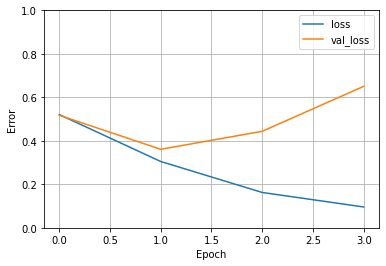

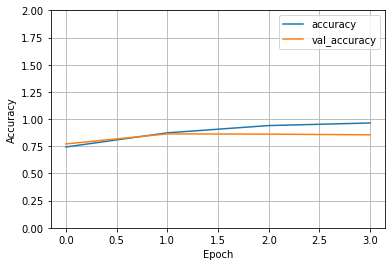

In [54]:
plot_loss(history)

I experimented with different types of architecture (also i tried adding CNN layers, which from my experience sometimes ight help), but could not get above 87% accuracy on testing set. The next step is to look at F1, ROC, AUC and save the results for later comparison with different types of models. 

Possible **solutions** for "poor" result is:
1. look at badly classified examples and try to find some pattern in them and remove it or maybe hardcode some rules.
2. Try to improve hyperparameters of model.
3. Use different types of regularizational techniques.
4. Try to use lemmatization and removing stop words 

In [25]:
X_train_pred = model.predict(X_train_padded_NN)
X_test_pred = model.predict(X_test_padded_NN)

In [70]:
X_train_p = np.array([x[0] for x in X_train_pred])
X_test_p = np.array([x[0] for x in X_test_pred])


[[1879  574]
 [ 251 2997]]


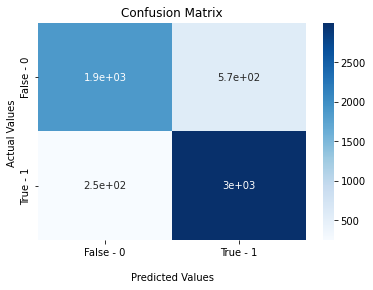

In [41]:
from sklearn.metrics import confusion_matrix

#first is category 0 then category 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, X_test_p.round())
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False - 0','True - 1'])
ax.yaxis.set_ticklabels(['False - 0','True - 1'])

## Display the visualization of the Confusion Matrix.
plt.show()

From the previous we can see that number of user suggestions with value 1, which were misclassified is 251. And number of suggestions with value 0, which were misclassified is 574. And so:

- **Precision** (percentage of classified suggestions from category 1 by our model, where actual from class 1) = **84%** = 2997 / (2997+579)

- **Recall** (percentage of actual suggestions from category 1 which were correctly classified by our model) = **92.2%** = 2997 / (2997+251)

We will also look at some **diagnostic graphs** and then compare them with rest of models.


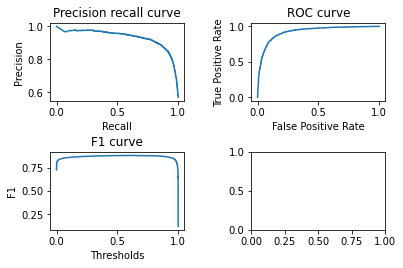

AUC score for (TPR, FPR) - graph:  0.9232
AUC-PR for (precision - recall) graph: 0.9335


In [49]:
diag_graphs(model, X_test_padded_NN, y_test)

#  Stacking 

is a type of ensemble learning, which combines results of more models together. In our case we will use th results of previous nerural network stack them together with training set (we will add another column with name **pred**) and we will built *second layer* model on this set. The reason is also, that we want to incorporate the iinformation from **year** column into our prediciton (the "string" variables were used in NN model).


But for the need of other machine learning models we need to input missing values in the variable *year*. We will use kNN imputer technique, which is based on k nearest points *neighbours*. 

In [109]:
X_trainm = process_dat(X_train)
X_trainm = knn_inputer(X_trainm)

X_train.year = X_trainm.year.values
print(X_train.isnull().sum())

X_train['pred'] = X_train_p

X_testm = process_dat(X_test)
X_testm = knn_inputer(X_testm)

X_test.year = X_testm.year.values
print(X_test.isnull().sum())

X_test['pred'] =  X_test_p

review_id          0
title              0
year               0
user_review        0
user_suggestion    0
developer          0
publisher          0
tags               0
overview           0
text               0
pred               0
dtype: int64
review_id          0
title              0
year               0
user_review        0
user_suggestion    0
developer          0
publisher          0
tags               0
overview           0
text               0
predictions        0
pred               0
dtype: int64


In [111]:
X_train_m = X_train.loc[:,['year','pred']]
X_test_m = X_test.loc[:,['year','pred']]

In [134]:
pred, prob = XGB_function(X_train_m, y_train, X_test_m, y_test, X_test_m)

results = confusion_matrix(y_test, pred)
print(results)
print("")

p,r,f,_ = precision_recall_fscore_support(y_test, pred)
print("Precision of DT has value {}, recall has value {} and F1 score is {}.".format(round(p[1],2),round(r[1],2),round(f[1],2)))

Accuracy of Extreme boosted classifier on training set: 0.99
Accuracy of Extreme boosted classifier on test set: 0.86
[[2004  449]
 [ 358 2890]]

Precision of DT has value 0.87, recall has value 0.89 and F1 score is 0.88.


In [133]:
pred, prob = LogisticRegression_function(X_train_m, y_train, X_test_m, y_test, X_test_m)

results = confusion_matrix(y_test, pred)
print(results)
print("")

p,r,f,_ = precision_recall_fscore_support(y_test, pred)
print("Precision of DT has value {}, recall has value {} and F1 score is {}.".format(round(p[1],2),round(r[1],2),round(f[1],2)))

Accuracy of Logistic regression classifier on training set: 0.98
Accuracy of Logistic regression on test set: 0.86
[[1942  511]
 [ 294 2954]]

Precision of DT has value 0.85, recall has value 0.91 and F1 score is 0.88.


In [132]:
pred, prob = DecisionTree_function(X_train_m, y_train, X_test_m, y_test, X_test_m)

results = confusion_matrix(y_test, pred)
print(results)
print("")

p,r,f,_ = precision_recall_fscore_support(y_test, pred)
print("Precision of DT has value {}, recall has value {} and F1 score is {}.".format(round(p[1],2),round(r[1],2),round(f[1],2)))

Accuracy of DecisionTree classifier on training set: 1.00
Accuracy of DecisionTree on test set: 0.85
[[1974  479]
 [ 384 2864]]

Precision of DT has value 0.86, recall has value 0.88 and F1 score is 0.87.


From the previous results we see, that recall neither precision were improved, so far we would choose simpler model and so the basic LSTM neural network.

# 2. **Bidirectional LSTM** (+ CNN) with removing stop words and lematization


The next procecss will be identical with the previous one, although the change will be that, we try to improve prediction power with **lemmatization** and **removing stop words**. This could lead into possible results:

- we improve prediction power, because we loose noise from sentence
- or we will sort of loose some *sense* from sentences.

In [139]:
def lemmatization_stop_words(x):
  
  lemmatizer = WordNetLemmatizer()

  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(x)

  filtered_sentence = [lemmatizer.lemmatize(w) for w in word_tokens if not w.lower() in stop_words]
  
  return " ".join(filtered_sentence)

In [142]:
X_ls = X
X_ls.text = X_ls.text.apply(lambda x: lemmatization_stop_words(x))

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.33, random_state=42)

In [156]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [157]:
print("The longest sequence is {} words long.".format(max([len(x) for x in X_train_NN])))
pd.DataFrame([len(x) for x in X_train_NN]).describe()

The longest sequence is 11120 words long.


,0
count,11572.000000
mean,2147.989976
std,1097.621905
min,303.000000
25%,1433.750000
50%,1887.000000
75%,2591.500000
max,11120.000000


In [158]:
max_length = 5000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 35863
#training_size = 20000

tokenizer_1 = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer_1.fit_on_texts(X_train_NN)

print('Vocabulary is {} words large'.format(len(tokenizer_1.word_index)))

Vocabulary is 35863 words large


In [159]:
sorted(tokenizer_1.word_counts.items(), key = lambda t: t[1])[35853:]

[('’', 17128),
 ('new', 19410),
 ('battle', 23946),
 ('multiplayer', 24905),
 ('player', 25686),
 ('free', 32029),
 ('world', 32881),
 ('play', 44432),
 ('game', 72558)]

We can now clearly see, that we removed stop words!!!

In [160]:
X_train_NN = tokenizer_1.texts_to_sequences(X_train_NN)
X_train_padded_NN = np.array(pad_sequences(X_train_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

X_test_NN = tokenizer_1.texts_to_sequences(X_test_NN)
X_test_padded_NN = np.array(pad_sequences(X_test_NN, maxlen=max_length, padding=padding_type, truncating=trunc_type))

In [161]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model_1 = tf.keras.Sequential()

model_1.add(Embedding(vocab_size,240, input_length = max_length))
model_1.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model_1.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model_1.add(Dropout(0.5)),
model_1.add(Flatten()),
model_1.add(Dropout(0.5)),
model_1.add(Dense(1,activation = 'sigmoid'))


model_1.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = METRICS)

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5000, 240)         8607120   
                                                                 
 bidirectional_10 (Bidirecti  (None, 5000, 128)        156160    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 5000, 64)         41216     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 5000, 64)          0         
                                                                 
 flatten_5 (Flatten)         (None, 320000)            0         
                                                                 
 dropout_9 (Dropout)         (None, 320000)           

In [162]:
%%time

history_1 = model_1.fit(X_train_padded_NN, y_train, epochs=4, validation_data=(X_test_padded_NN, y_test), verbose = 1)

Epoch 1/4
362/362 [==============================] - 256s 692ms/step - loss: 0.5378 - accuracy: 0.7397 - precision: 0.7493 - recall: 0.8145 - val_loss: 0.4542 - val_accuracy: 0.7958 - val_precision: 0.7650 - val_recall: 0.9261
Epoch 2/4
362/362 [==============================] - 250s 692ms/step - loss: 0.3102 - accuracy: 0.8734 - precision: 0.8769 - recall: 0.9042 - val_loss: 0.3955 - val_accuracy: 0.8449 - val_precision: 0.8835 - val_recall: 0.8384
Epoch 3/4
362/362 [==============================] - 252s 696ms/step - loss: 0.1579 - accuracy: 0.9425 - precision: 0.9417 - recall: 0.9582 - val_loss: 0.5485 - val_accuracy: 0.8497 - val_precision: 0.8728 - val_recall: 0.8618
Epoch 4/4
362/362 [==============================] - 252s 696ms/step - loss: 0.0908 - accuracy: 0.9666 - precision: 0.9688 - recall: 0.9725 - val_loss: 0.8638 - val_accuracy: 0.8323 - val_precision: 0.8795 - val_recall: 0.8177
CPU times: user 16min 37s, sys: 25.6 s, total: 17min 3s
Wall time: 17min 27s


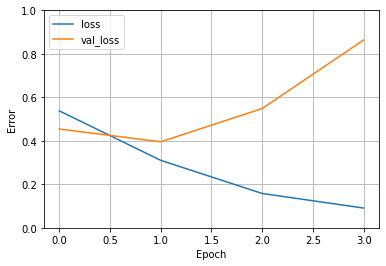

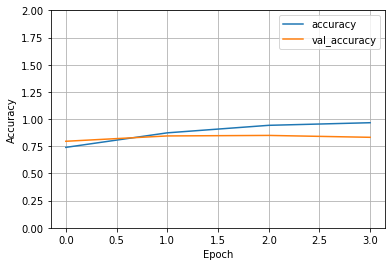

In [163]:
plot_loss(history_1)

In [164]:
X_train_pred = model_1.predict(X_train_padded_NN)
X_test_pred = model_1.predict(X_test_padded_NN)

In [165]:
X_train_p = np.array([x[0] for x in X_train_pred])
X_test_p = np.array([x[0] for x in X_test_pred])

[[2089  364]
 [ 592 2656]]


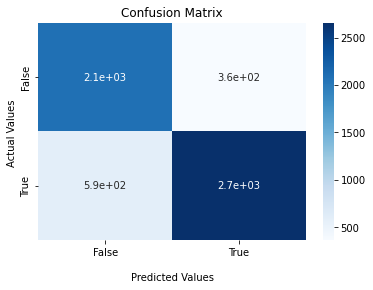

In [167]:
from sklearn.metrics import confusion_matrix

#first is category 0 then catgory 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, X_test_p.round())
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

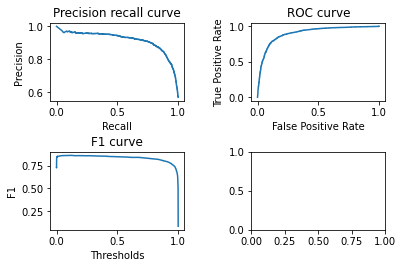

AUC score for (TPR, FPR) - graph:  0.9046
AUC-PR for (precision - recall) graph: 0.9166


In [169]:
diag_graphs(model_1, X_test_padded_NN, y_test)

So we can see, that prediciton power slightly decresed. Probably due to imformation loss. Results of three metrics which we used:

- **Accuracy** is **83.2%**, which is smaller value compared to model with stop words (**85.5%**) 
- **Precision** is **88%**, which is a little bit better than previous model (**84%**)
- Value of **recall** is **82%** < **92.2%**

All in all, the best model is still the first one without stacking method.

# 3. **BERT** - transformer for text classification without removing stop words and lematization. 

In [197]:
!pip install tensorflow_text

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [199]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [200]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [201]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l_1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l_2 = tf.keras.layers.Dense(128, activation='relu', name="output1")(l_1)
l_3 = tf.keras.layers.Dense(64, activation='relu', name="output2")(l_2)
l_4 = tf.keras.layers.Dense(32, activation='relu', name="output3")(l_3)
l_5 = tf.keras.layers.Dense(1, activation='sigmoid', name="output4")(l_4)

# Use inputs and outputs to construct a final model
model_3 = tf.keras.Model(inputs=[text_input], outputs = [l_5])

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [202]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [210]:
history_3 = model_3.fit(X_train_NN, y_train, epochs=5, validation_data=(X_test_NN, y_test), verbose = 1)

Epoch 1/5
362/362 [==============================] - 193s 535ms/step - loss: 0.5589 - accuracy: 0.7093 - precision: 0.6933 - recall: 0.8678 - val_loss: 0.5467 - val_accuracy: 0.7206 - val_precision: 0.6951 - val_recall: 0.9232
Epoch 2/5
362/362 [==============================] - 194s 535ms/step - loss: 0.5613 - accuracy: 0.7044 - precision: 0.6910 - recall: 0.8594 - val_loss: 0.5364 - val_accuracy: 0.7190 - val_precision: 0.7112 - val_recall: 0.8682
Epoch 3/5
362/362 [==============================] - 194s 535ms/step - loss: 0.5597 - accuracy: 0.7044 - precision: 0.6883 - recall: 0.8686 - val_loss: 0.5673 - val_accuracy: 0.7196 - val_precision: 0.7234 - val_recall: 0.8361
Epoch 4/5
362/362 [==============================] - 193s 534ms/step - loss: 0.5562 - accuracy: 0.7058 - precision: 0.6914 - recall: 0.8626 - val_loss: 0.5507 - val_accuracy: 0.7096 - val_precision: 0.7528 - val_recall: 0.7433
Epoch 5/5
362/362 [==============================] - 193s 534ms/step - loss: 0.5556 - accura

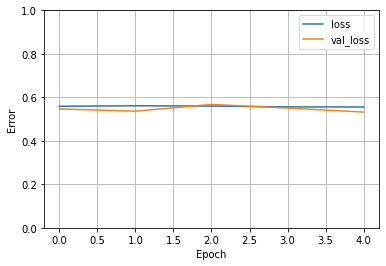

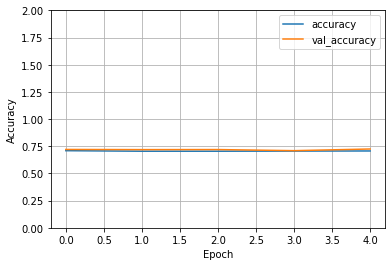

In [211]:
plot_loss(history_3)

In [212]:
X_train_pred = model_3.predict(X_train_NN)
X_test_pred = model_3.predict(X_test_NN)

In [213]:
X_train_p = np.array([x[0] for x in X_train_pred])
X_test_p = np.array([x[0] for x in X_test_pred])

[[1265 1130]
 [ 439 2868]]


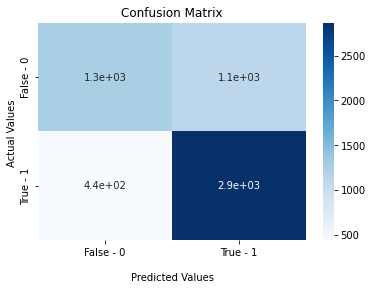

In [214]:
from sklearn.metrics import confusion_matrix

#first is category 0 then category 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, X_test_p.round())
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False - 0','True - 1'])
ax.yaxis.set_ticklabels(['False - 0','True - 1'])

## Display the visualization of the Confusion Matrix.
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


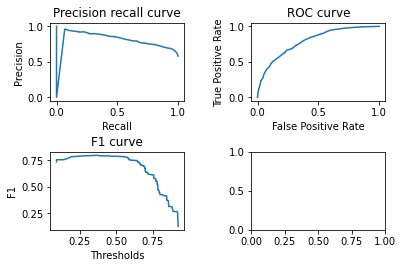

AUC score for (TPR, FPR) - graph:  0.7933
AUC-PR for (precision - recall) graph: 0.7983


In [209]:
diag_graphs(model_3, X_test_NN, y_test)

# 4. **BERT** - transformer for text classification with removing stop words and lematization.

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_ls, y, test_size=0.33, random_state=42)

ValueError: ignored

In [ ]:
X_train_NN = X_train.text.values
X_test_NN = X_test.text.values

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l_1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l_2 = tf.keras.layers.Dense(128, activation='relu', name="output1")(l_1)
l_3 = tf.keras.layers.Dense(64, activation='relu', name="output2")(l_2)
l_4 = tf.keras.layers.Dense(32, activation='relu', name="output3")(l_3)
l_5 = tf.keras.layers.Dense(1, activation='sigmoid', name="output4")(l_4)

# Use inputs and outputs to construct a final model
model_4 = tf.keras.Model(inputs=[text_input], outputs = [l_5])

model_4.summary()

In [ ]:
model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
history_4 = model_4.fit(X_train_NN, y_train, epochs=5, validation_data=(X_test_NN, y_test), verbose = 1)

In [ ]:
plot_loss(history_4)

In [ ]:
X_train_pred = model_4.predict(X_train_NN)
X_test_pred = model_4.predict(X_test_NN)

In [ ]:
X_train_p = np.array([x[0] for x in X_train_pred])
X_test_p = np.array([x[0] for x in X_test_pred])

In [ ]:
from sklearn.metrics import confusion_matrix

#first is category 0 then category 1. Check:
#np.logical_and((y_test ==1),np.array([x[0] for x in (round(X_test_p) == 1).values])).sum()

results = confusion_matrix(y_test, X_test_p.round())
print(results)

import seaborn as sns

ax = sns.heatmap(results, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False - 0','True - 1'])
ax.yaxis.set_ticklabels(['False - 0','True - 1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
diag_graphs(model_4, X_test_padded_NN, y_test)